1. **Data Preprocessing**
   - Data loading and preprocessing (e.g., normalization, resizing, augmentation).
   - Create visualizations of some images, and labels.

In [1]:
# 1. Data Preprocessing
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization, Dropout

# Cargar CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

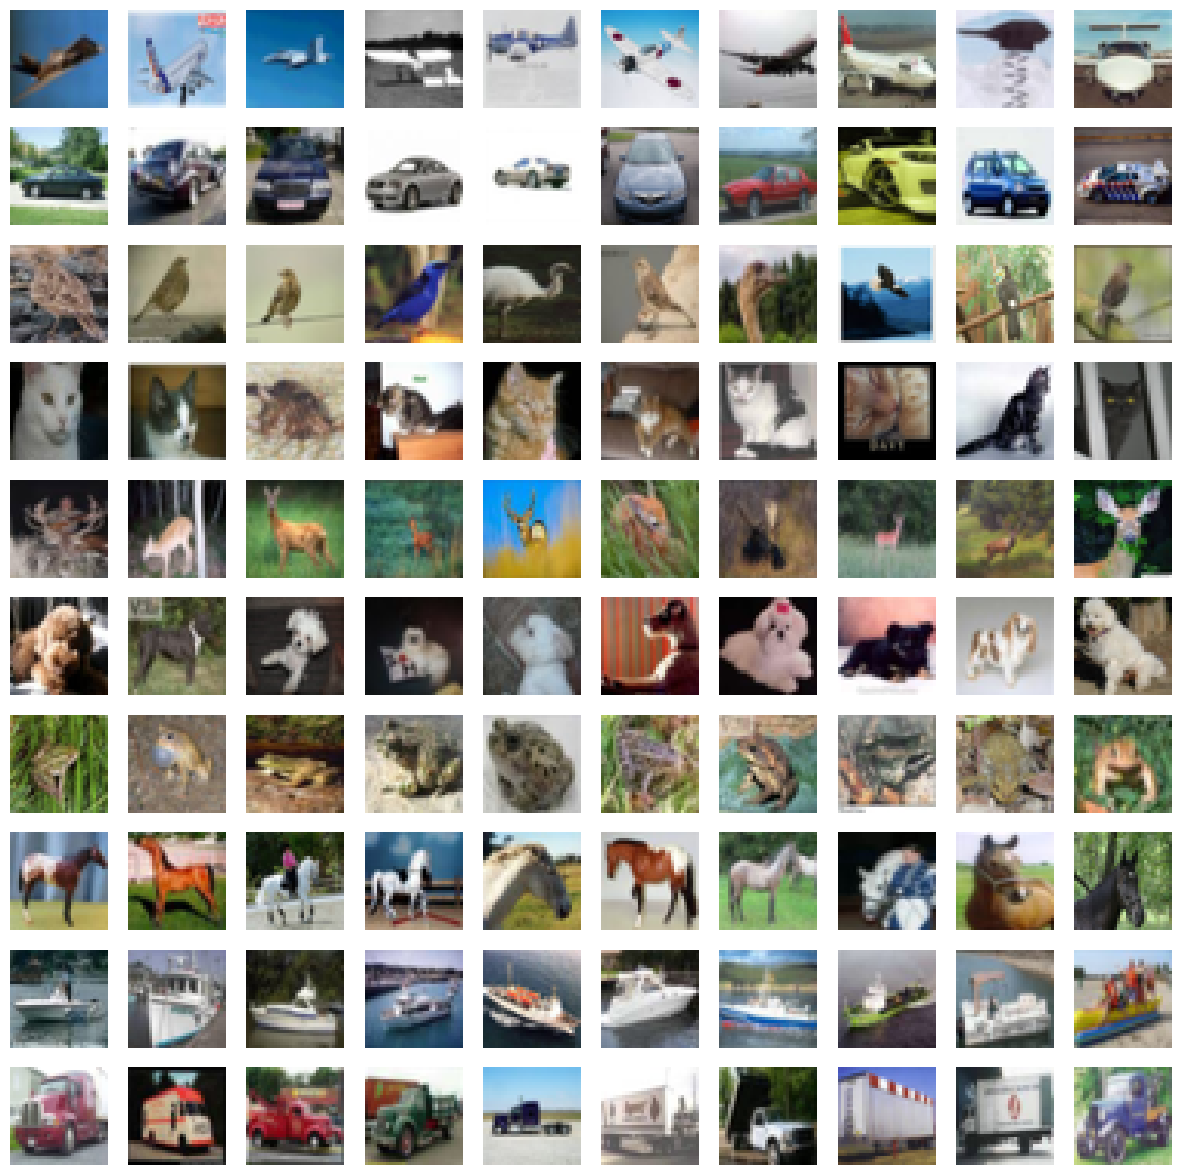

In [2]:
# Visualizar muestras
num_classes = 10
samples_per_class = 10
fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(15, 15))

for i in range(num_classes):
    class_indices = np.where(y_train == i)[0]
    random_indices = np.random.choice(class_indices, samples_per_class, replace=False)
    for j, idx in enumerate(random_indices):
        ax = axes[i, j]
        ax.imshow(x_train[idx])
        ax.axis('off')

plt.show()

In [3]:
# Preprocesamiento
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [4]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)
datagen.fit(x_train)

2. **Model Architecture**
   - Design a CNN architecture suitable for image classification.
   - Include convolutional layers, pooling layers, and fully connected layers.

In [5]:
# Your code here :
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [6]:
model = Sequential([
    Conv2D(64, (3,3), padding='same', activation='relu', input_shape=(32,32,3)),
    BatchNormalization(),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.3),
    
    Conv2D(128, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.4),
    
    Conv2D(256, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(256, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.5),
    
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

/opt/anaconda3/envs/tfgpu/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-12-19 10:11:30.185029: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2024-12-19 10:11:30.185069: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-12-19 10:11:30.185081: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-12-19 10:11:30.185278: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-19 10:11:30.185293: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc

3. **Model Training**
   - Train the CNN model using appropriate optimization techniques (e.g., stochastic gradient descent, Adam).
   - Utilize techniques such as early stopping to prevent overfitting.

In [7]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
             loss='categorical_crossentropy',
             metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)

In [8]:
history = model.fit(x_train, y_train,
                   batch_size=1024,
                   epochs=100,
                   validation_split=0.2,
                   callbacks=[early_stopping, reduce_lr])

Epoch 1/100


2024-12-19 10:11:31.788439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 928ms/step - accuracy: 0.2819 - loss: 2.6203 - val_accuracy: 0.1186 - val_loss: 3.2501 - learning_rate: 0.0010
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.4480 - loss: 1.6015 - val_accuracy: 0.0980 - val_loss: 3.3842 - learning_rate: 0.0010
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.5247 - loss: 1.3749 - val_accuracy: 0.0954 - val_loss: 3.4917 - learning_rate: 0.0010
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.5782 - loss: 1.2080 - val_accuracy: 0.1217 - val_loss: 3.4340 - learning_rate: 0.0010
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 37s 929ms/step - accuracy: 0.6285 - loss: 1.0686 - val_accuracy: 0.1750 - val_loss: 3.9631 - learning_rate: 0.0010
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 39s 964ms/step - accuracy: 0.6700 - loss: 0.9425 - val_accuracy: 0.1131 - val_loss: 4.1512 - learning_rate: 0.0010
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 38s 952ms/step - accuracy: 0.6980 - loss: 0.8610 - val_acc

KeyboardInterrupt: 

4. **Model Evaluation**
   - Evaluate the trained model on a separate validation set.
   - Compute and report metrics such as accuracy, precision, recall, and F1-score.
   - Visualize the confusion matrix to understand model performance across different classes.

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# Predicciones
predictions = model.predict(x_test)
predictions_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Asegurarse de que las clases estén en el rango correcto (0-9 para CIFAR-10)
print("Rango de predicciones:", np.min(predictions_classes), "-", np.max(predictions_classes))
print("Rango de valores reales:", np.min(true_classes), "-", np.max(true_classes))

# Calcular métricas solo si los rangos son correctos
if (0 <= np.min(predictions_classes) <= 9) and (0 <= np.max(predictions_classes) <= 9):
    print("\nMatriz de Confusión:")
    print(confusion_matrix(true_classes, predictions_classes))

    print("\nMétricas de Evaluación:")
    print(f"F1-Score: {f1_score(true_classes, predictions_classes, average='weighted'):.4f}")
    print(f"Precisión: {precision_score(true_classes, predictions_classes, average='weighted'):.4f}")
    print(f"Recall: {recall_score(true_classes, predictions_classes, average='weighted'):.4f}")
else:
    print("Error: Las predicciones no están en el rango esperado")

5. **Transfer Learning**
    - Evaluate the accuracy of your model on a pre-trained models like ImagNet, VGG16, Inception... (pick one an justify your choice)
        - You may find this [link](https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub) helpful.
        - [This](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) is the Pytorch version.
    - Perform transfer learning with your chosen pre-trained models i.e., you will probably try a few and choose the best one.

In [10]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# Cargar VGG16 pre-entrenado
base_model = VGG16(weights='imagenet', 
                   include_top=False, 
                   input_shape=(32, 32, 3))
                   #classifier_activation="SoftMax"))

# Congelar capas base
for layer in base_model.layers:
    layer.trainable = False

# Crear modelo de transfer learning
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(10, activation='softmax')(x)

transfer_model = Model(inputs=base_model.input, outputs=predictions)

# Entrenar modelo de transfer learning
transfer_model.compile(optimizer=Adam(learning_rate=0.001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

history_transfer = transfer_model.fit(x_train, 
                                    y_train,
                                    batch_size=128,
                                    epochs=50,
                                    validation_data=(x_test, y_test),
                                    callbacks=[early_stopping, reduce_lr])

# Evaluar métricas después del transfer learning
predictions = transfer_model.predict(x_test)
predictions_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

print("\nMétricas después del transfer learning:")
print(f"F1-Score: {f1_score(true_classes, predictions_classes, average='weighted'):.4f}")
print(f"Precisión: {precision_score(true_classes, predictions_classes, average='weighted'):.4f}")
print(f"Recall: {recall_score(true_classes, predictions_classes, average='weighted'):.4f}")


Epoch 1/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.3744 - loss: 1.7993 - val_accuracy: 0.5474 - val_loss: 1.3010 - learning_rate: 0.0010
Epoch 2/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - accuracy: 0.5273 - loss: 1.3583 - val_accuracy: 0.5599 - val_loss: 1.2639 - learning_rate: 0.0010
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.5482 - loss: 1.2951 - val_accuracy: 0.5690 - val_loss: 1.2370 - learning_rate: 0.0010
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.5595 - loss: 1.2735 - val_accuracy: 0.5713 - val_loss: 1.2375 - learning_rate: 0.0010
Epoch 5/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - accuracy: 0.5553 - loss: 1.2771 - val_accuracy: 0.5710 - val_loss: 1.2297 - learning_rate: 0.0010
Epoch 6/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.5644 - loss: 1.2654 - val_accuracy: 0.5726 - val_loss: 1.2207 - learning_rate: 0.0010
Epoch 7/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.5635 - l

In [11]:
# Fine-tuning
for layer in base_model.layers[-4:]:
    layer.trainable = True

transfer_model.compile(optimizer=Adam(learning_rate=0.0001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

history_fine_tuning = transfer_model.fit(x_train, 
                                       y_train,
                                       batch_size=128,
                                       epochs=30,
                                       validation_data=(x_test, y_test),
                                       callbacks=[early_stopping, reduce_lr])

# Evaluar métricas después del fine-tuning
predictions = transfer_model.predict(x_test)
predictions_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

print("\nMétricas después del fine-tuning:")
print(f"F1-Score: {f1_score(true_classes, predictions_classes, average='weighted'):.4f}")
print(f"Precisión: {precision_score(true_classes, predictions_classes, average='weighted'):.4f}")
print(f"Recall: {recall_score(true_classes, predictions_classes, average='weighted'):.4f}")

Epoch 1/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 25s 60ms/step - accuracy: 0.5608 - loss: 1.3997 - val_accuracy: 0.6687 - val_loss: 0.9876 - learning_rate: 1.0000e-04
Epoch 2/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 23s 58ms/step - accuracy: 0.6673 - loss: 1.0459 - val_accuracy: 0.6971 - val_loss: 0.8936 - learning_rate: 1.0000e-04
Epoch 3/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 23s 58ms/step - accuracy: 0.7143 - loss: 0.8543 - val_accuracy: 0.7104 - val_loss: 0.8715 - learning_rate: 1.0000e-04
Epoch 4/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 23s 58ms/step - accuracy: 0.7535 - loss: 0.7235 - val_accuracy: 0.7117 - val_loss: 0.8779 - learning_rate: 1.0000e-04
Epoch 5/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 24s 61ms/step - accuracy: 0.7887 - loss: 0.6120 - val_accuracy: 0.7402 - val_loss: 0.7986 - learning_rate: 1.0000e-04
Epoch 6/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - accuracy: 0.8242 - loss: 0.5058 - val_accuracy: 0.7378 - val_loss: 0.8179 - learning_rate: 1.0000e-04
Epoch 7/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/ste

In [13]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# Predicciones
predictions = transfer_model.predict(x_test)  # Nota: cambiado de base_model a transfer_model
predictions_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Asegurarse de que las clases estén en el rango correcto (0-9 para CIFAR-10)
print("Rango de predicciones:", np.min(predictions_classes), "-", np.max(predictions_classes))
print("Rango de valores reales:", np.min(true_classes), "-", np.max(true_classes))

# Calcular métricas solo si los rangos son correctos
if (0 <= np.min(predictions_classes) <= 9) and (0 <= np.max(predictions_classes) <= 9):
    print("\nMatriz de Confusión:")
    print(confusion_matrix(true_classes, predictions_classes))

    print("\nMétricas de Evaluación:")
    print(f"F1-Score: {f1_score(true_classes, predictions_classes, average='weighted'):.4f}")
    print(f"Precisión: {precision_score(true_classes, predictions_classes, average='weighted'):.4f}")
    print(f"Recall: {recall_score(true_classes, predictions_classes, average='weighted'):.4f}")
else:
    print("Error: Las predicciones no están en el rango esperado")

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
Rango de predicciones: 0 - 9
Rango de valores reales: 0 - 9

Matriz de Confusión:
[[832  15  22  15  15   3   9  10  57  22]
 [ 17 841   6   8   3   8   5   1  21  90]
 [ 46   8 674  56  77  38  68  18   5  10]
 [ 15   9  35 567  51 184  78  25  15  21]
 [ 13   4  34  47 743  33  65  45  10   6]
 [  8   5  25 170  38 675  28  36   0  15]
 [  4   5  34  47  46  31 817   4   7   5]
 [  7   3  20  35  58  52   9 801   0  15]
 [ 43  32   7   8   9   2   7   2 870  20]
 [ 29  79   7  16   8   8   7  12  20 814]]

Métricas de Evaluación:
F1-Score: 0.7630
Precisión: 0.7640
Recall: 0.7634


6. **Code Quality**
   - Well-structured and commented code.
   - Proper documentation of functions and processes.
   - Efficient use of libraries and resources.

6. **Report**
   - Write a concise report detailing the approach taken, including:
     - Description of the chosen CNN architecture.
     - Explanation of preprocessing steps.
     - Details of the training process (e.g., learning rate, batch size, number of epochs).
     - Results and analysis of models performance.
     - What is your best model. Why?
     - Insights gained from the experimentation process.
   - Include visualizations and diagrams where necessary.

7. **Model deployment**
     - Pick the best model 
     - Build an app using Flask - Can you host somewhere other than your laptop? **+5 Bonus points if you use [Tensorflow Serving](https://www.tensorflow.org/tfx/guide/serving)**
     - User should be able to upload one or multiples images get predictions including probabilities for each prediction

In [ ]:
# Guardar el mejor modelo (el que tenga mejor rendimiento entre el base y transfer learning)
model.save('best_model.keras')

# Crear aplicación Flask
from flask import Flask, request, jsonify
from PIL import Image
from tensorflow.keras.models import load_model

app = Flask(__name__)
model = load_model('best_model.h5')

@app.route('/predict', methods=['POST'])
def predict():
    file = request.files['image']
    img = Image.open(file)
    img = img.resize((32, 32))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    pred = model.predict(img_array)
    class_idx = np.argmax(pred[0])
    confidence = float(pred[0][class_idx])
    
    return jsonify({
        'class': int(class_idx),
        'confidence': confidence
    })

if __name__ == '__main__':
    app.run(debug=True)